##### Data Understanding & Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_csv('fruit_classification_dataset.csv')
df.head()

,size (cm),shape,weight (g),avg_price,color,taste,fruit_name
0,25.4,round,3089.2,137.1,green,sweet,watermelon
1,24.6,round,3283.9,163.8,green,sweet,watermelon
2,7.8,round,319.0,91.3,green,sweet,custard apple
3,20.0,oval,1607.0,85.7,orange,sweet,papaya
4,10.2,long,131.5,37.8,yellow,sweet,banana


In [3]:
#df.info
#df.shape
#df.dtypes
#df.describe()
df.isnull().sum()

size (cm)     0
shape         0
weight (g)    0
avg_price     0
color         0
taste         0
fruit_name    0
dtype: int64

##### Exploratory Data Analysis

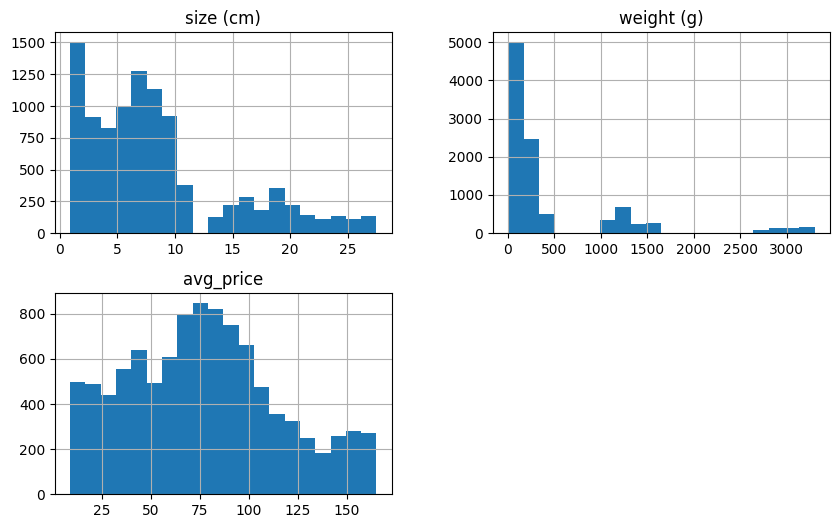

In [4]:
# Let's see the distribution our data has

df[['size (cm)', 'weight (g)','avg_price']].hist(bins=20, figsize=(10,6))
plt.show()

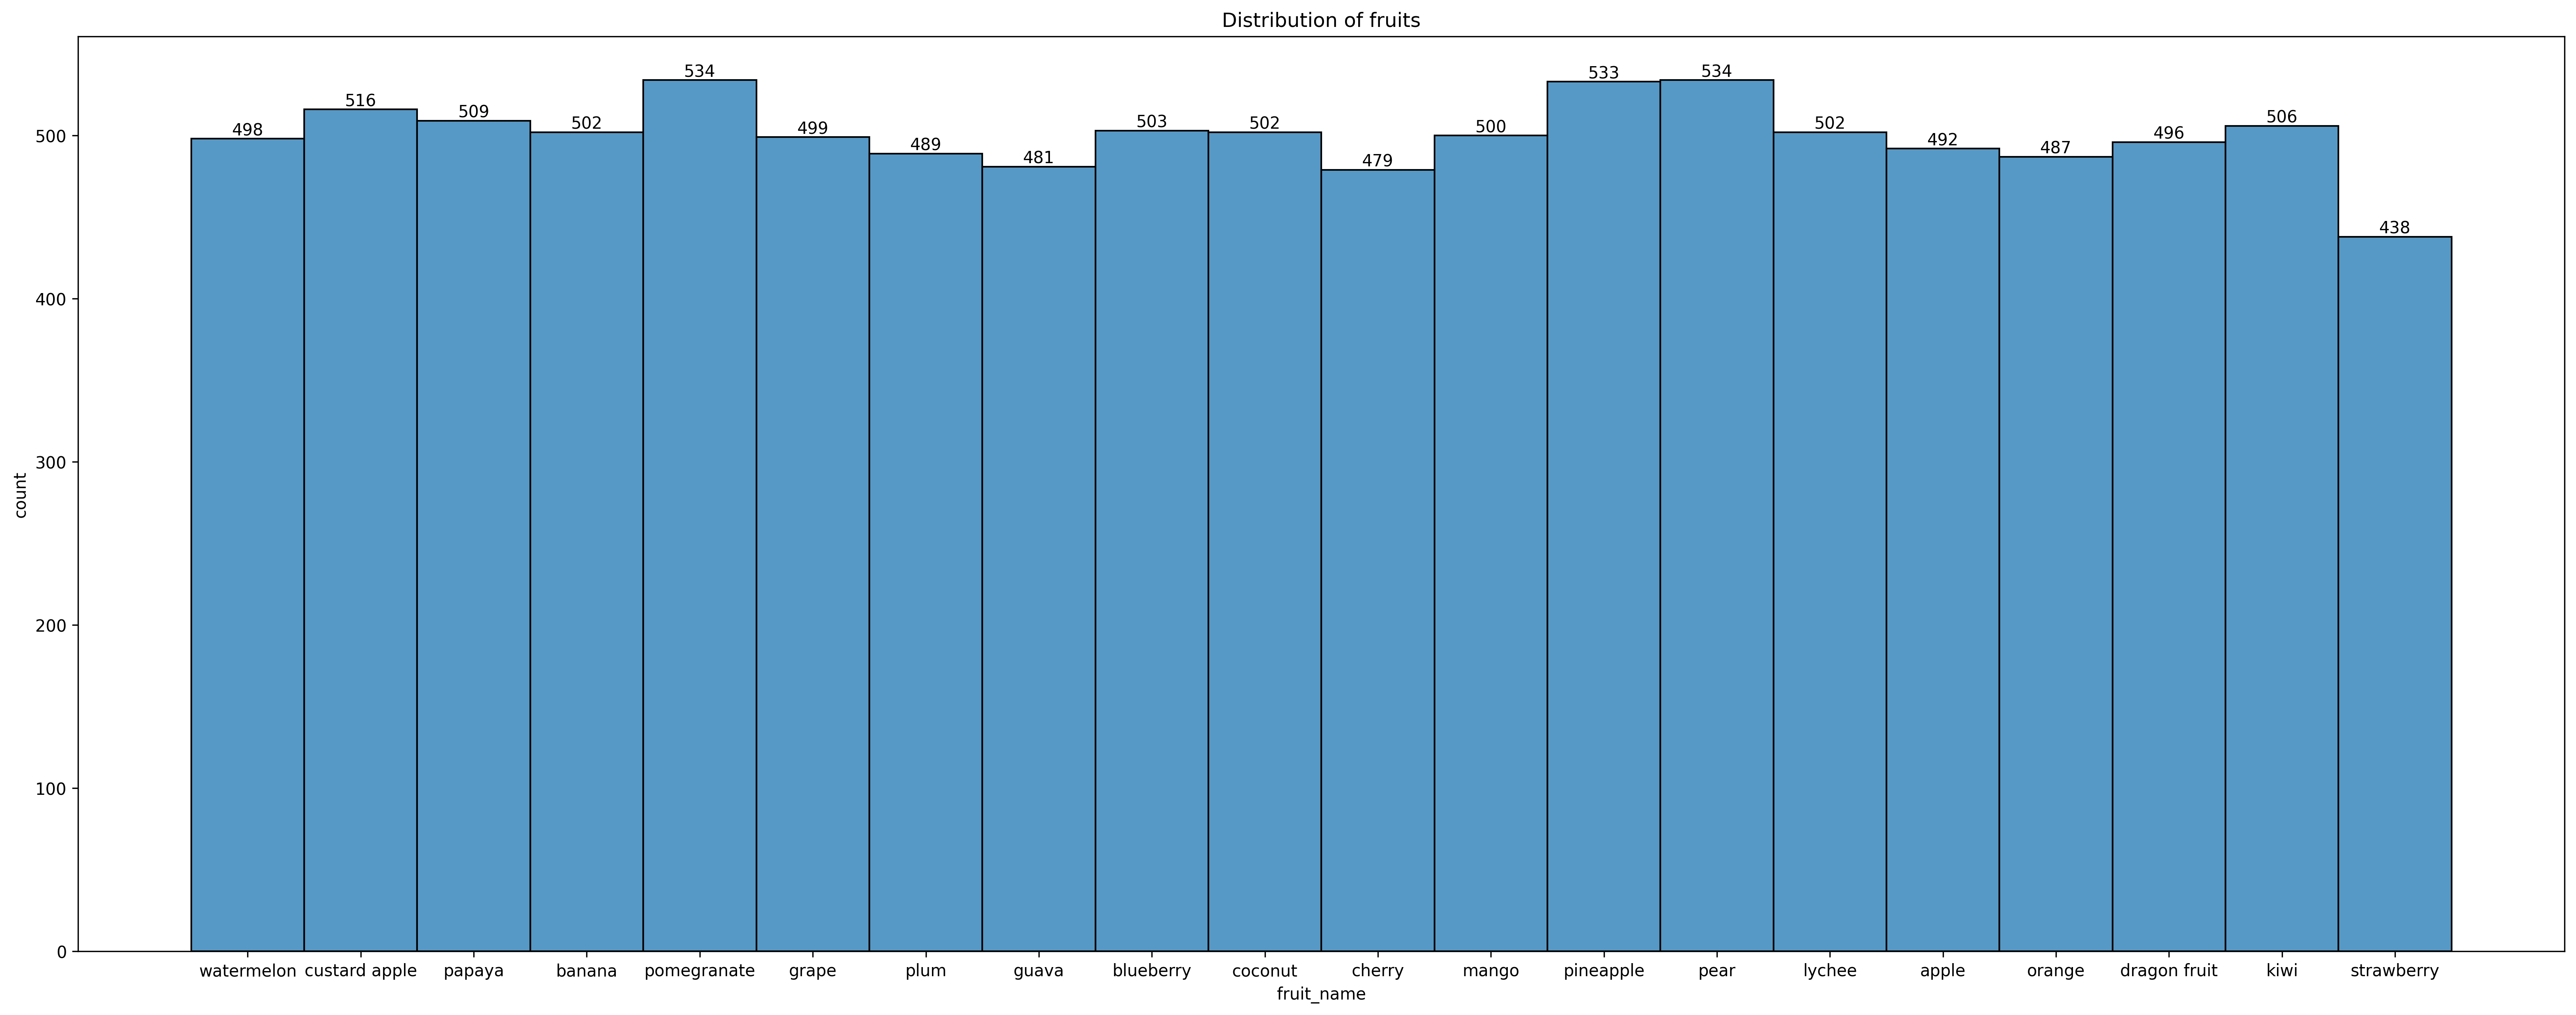

In [5]:
plt.figure(figsize=(27, 10), dpi=300)

y = sns.histplot(df.fruit_name)
y.bar_label(y.containers[0], labels=y.containers[0].datavalues)

plt.title("Distribution of fruits")
plt.xlabel("fruit_name")
plt.ylabel("count");

##### Feature Engineering

In [6]:
target = 'fruit_name'
features =['size (cm)', 'shape', 'weight (g)', 'avg_price', 'color', 'taste']

##### Splitting and Encoding

In [7]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

(8000, 2000)

In [8]:
df_train, df_val =train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(6000, 2000, 2000)

In [9]:
# Seperate the Target
y_train = df_train.fruit_name.values
y_val = df_val.fruit_name.values
y_test = df_test.fruit_name.values

In [10]:
# Encode the y_train to 0's and 1's

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val= encoder.transform(y_val)
y_test= encoder.transform(y_test)

In [11]:
df_train =df_train.reset_index(drop=True)
df_val =df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
del df_train['fruit_name']
del df_val['fruit_name']
del df_test['fruit_name']

#### Mutual Information

In [13]:
y = df["fruit_name"]
X = df.drop("fruit_name", axis=1)

In [14]:
# This helps to encode your y_train
X_encoded = pd.get_dummies(X)

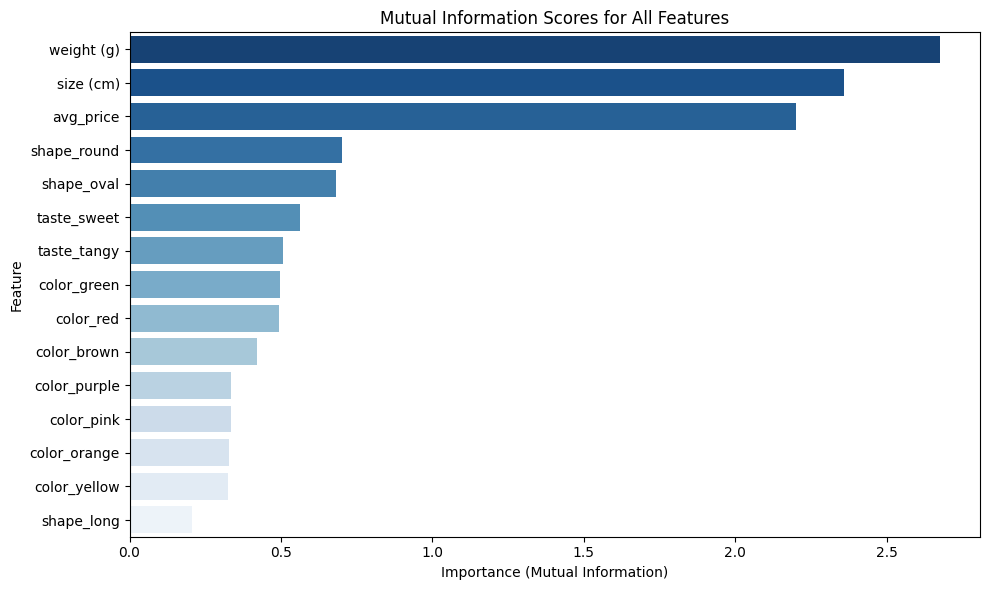

In [15]:
mi_scores = mutual_info_classif(X_encoded, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=mi_series.values[:15], y=mi_series.index[:15], hue=mi_series.index[:15], palette="Blues_r", legend=False)
plt.title("Mutual Information Scores for All Features")
plt.xlabel("Importance (Mutual Information)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()





#### Feature Engineering -> Vectorize(One-hot encode) features

In [16]:
# We need to turn the Data frame into a sparse matrix so that the model can read it, as it only recognises 0's and 1's

dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


### Model Training

In [17]:
# Now Let's train our data using 3-4 models and we select the best, after that we will use the df_full_train data to re-train on the best model
# Test it on our test data

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', n_estimators=100, random_state=1)
}

# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results.append((name, acc))
    print(f"{name} Accuracy: {acc:.3f}")


Decision Tree Accuracy: 1.000
Random Forest Accuracy: 1.000
XGBoost Accuracy: 1.000


## Hyper-Parameter Tuning

In [18]:
# Tuning Decision Trees

from sklearn.model_selection import RandomizedSearchCV

dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_distributions=dt_params,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=1,
    n_jobs=-1,
    verbose=2
)

dt_search.fit(X_train, y_train)
print("Best Decision Tree Params:", dt_search.best_params_)
print("Best Validation Accuracy:", dt_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Decision Tree Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15, 'criterion': 'gini'}
Best Validation Accuracy: 1.0


In [19]:
# Tuning Random Forest

rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=1),
    param_distributions=rf_params,
    n_iter=25,
    cv=3,
    scoring='accuracy',
    random_state=1,
    n_jobs=-1,
    verbose=2
)

rf_search.fit(X_train, y_train)
print("Best Random Forest Params:", rf_search.best_params_)
print("Best Validation Accuracy:", rf_search.best_score_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}
Best Validation Accuracy: 1.0


In [ ]:
# Tuning XGBOOST
# List all your parameters you'd like to tune the model with
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# we don't want to manually tune our models so lets automate using randomized search
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=1
    ),
    param_distributions=xgb_params,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=1,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_search.best_params_)
print("Best Validation Accuracy:", xgb_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.3, 'eta': 0.01, 'colsample_bytree': 1.0}
Best Validation Accuracy: 1.0


#### Comparing the Tuned Models on Validation Dataset

In [ ]:
tuned_models = {
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}

for name, model in tuned_models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} (tuned) Validation Accuracy: {acc:.3f}")


Decision Tree (tuned) Validation Accuracy: 1.000
Random Forest (tuned) Validation Accuracy: 1.000
XGBoost (tuned) Validation Accuracy: 1.000


#### Retrain on Full Training Data

In [ ]:
# I deleted the df_train before, so i now i want to recreate it from the y_train
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

# merge target arrays
y_full_train = np.concatenate([y_train, y_val])


dv = DictVectorizer(sparse=False)
dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

best_model = xgb_search.best_estimator_
best_model.fit(X_full_train, y_full_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


#### Evaluate final model on test data

In [ ]:
y_pred_test = best_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Final Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00        94
           3       1.00      1.00      1.00        98
           4       1.00      1.00      1.00        86
           5       1.00      1.00      1.00       101
           6       1.00      1.00      1.00        98
           7       1.00      1.00      1.00       112
           8       1.00      1.00      1.00        93
           9       1.00      1.00      1.00       106
          10       1.00      1.00      1.00        99
          11       1.00      1.00      1.00        84
          12       1.00      1.00      1.00        96
          13       1.00      1.00      1.00        97
          14       1.00      1.00      1.00       120
          15       1.00      1.00      1.00       107
          16       1.00      1.00      1.00       107
  

In [ ]:
# You already trained and saved the best model you can just Skip writing train.py, just use model.pkl

# You plan to retrain later or submit code for grading, Create train.py (clean, short script for reproducibility)